# Create Ground Truth

In [142]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

from datetime import date

In [143]:
def GroundTruthModel(gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)
    
    lambda1 = torch.tensor(0.2)
    lambda2 = torch.tensor(-0.1)
    lambda3 = torch.tensor(-0.8)
    lambda4 = torch.tensor(0.8)

    lambda5 = torch.tensor(0.8)
    lambda6 = torch.tensor(0.1)
    lambda7 = torch.tensor(-0.8)
    lambda8 = torch.tensor(0.2)
    
    u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u4 = pyro.sample("u4", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    
    a_prob = torch.sigmoid(gamma_shift * lambda1 * C + u1)
    a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob))
    a = pyro.sample("A", dist.Delta(a_val))
    
    r_val = pyro.sample("r", dist.Normal(torch.tensor(0.), torch.tensor(1.))) + lambda2 * a_val + u2 
    r = pyro.sample("R", dist.Delta(r_val))
    
    y_prob = torch.sigmoid(lambda3 * a_val + lambda4 * r_val + u3)
    y_val = pyro.sample("y", dist.Bernoulli(y_prob))
    y = pyro.sample("Y", dist.Delta(y_val))
    
    t_val = pyro.sample("t", dist.Normal(lambda5 * y_val + lambda6 * r_val + lambda7 * a_val + u4, 1. + gamma_shift * lambda8 * C))
    t = pyro.sample("T", dist.Delta(t_val))

In [144]:
trace_handler = pyro.poutine.trace(GroundTruthModel)
samples = pd.DataFrame(columns=['A', 'R', 'T', 'Y'])

In [145]:
num_samples = 2000
all_samples=[]
for i in range(num_samples):
    trace = trace_handler.get_trace()
    a = trace.nodes['A']['value'].numpy().item()
    r = trace.nodes['R']['value'].numpy().item()
    t = trace.nodes['T']['value'].numpy().item()
    y = trace.nodes['Y']['value'].numpy().item()
    samples = samples.append({'A': a, 'R': r, 'T': t, 'Y':y}, ignore_index=True)
    all_samples.append([a, r, t, y])
samples.head()

,A,R,T,Y
0,1.0,0.101660,-3.186716,0.0
1,1.0,-1.536095,-0.846939,0.0
2,0.0,-1.516211,-0.039877,0.0
3,1.0,0.452436,0.540617,0.0
4,1.0,1.935133,0.120729,1.0


/home/zainkhan/miniconda3/envs/digbio/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'R'}>],
       [<AxesSubplot:title={'center':'T'}>,
        <AxesSubplot:title={'center':'Y'}>]], dtype=object)

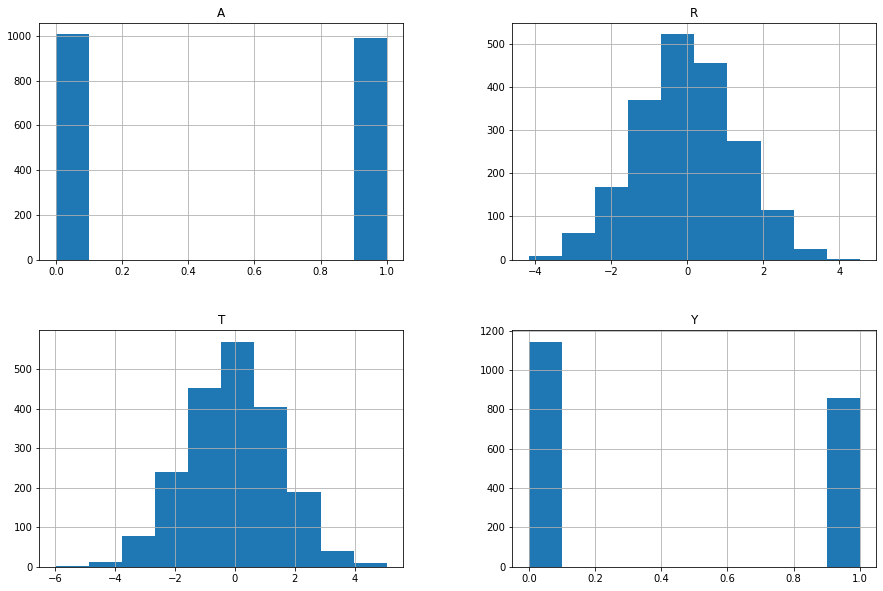

In [146]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)

samples.hist()

In [147]:
date_time = date.today().strftime('%m-%d-%Y')
samples.to_csv(f'{date_time}-pryo-source-groundtruth.csv', index=False)

#samples = pd.read_csv(f'{date_time}-pryo-source-groundtruth.csv')
#samples.head()

# Learn Parameters from Ground Truth

In [164]:
def ProposedModel(data, gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)

    lambda1 = pyro.sample("lambda1", dist.Normal(0., 1.))
    lambda2 = pyro.sample("lambda2", dist.Normal(0., 1.))
    lambda3 = pyro.sample("lambda3", dist.Normal(0., 1.))
    lambda4 = pyro.sample("lambda4", dist.Normal(0., 1.))

    lambda5 = pyro.sample("lambda5", dist.Normal(0., 1.))
    lambda6 = pyro.sample("lambda6", dist.Normal(0., 1.))
    lambda7 = pyro.sample("lambda7", dist.Normal(0., 1.))
    lambda8 = pyro.sample("lambda8", dist.Normal(0., 1.))
    
    with pyro.plate("data", data.size(0)):
        u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u4 = pyro.sample("u4", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
        
        a_prob = torch.sigmoid(gamma_shift * lambda1 * C + u1)
        a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob), obs=data[:,0])

        r_val = pyro.sample("r", dist.Normal(lambda2 * a_val + u2, 1.), obs=data[:,1]) 

        y_prob = torch.sigmoid(lambda3 * a_val + lambda4 * r_val + u3)
        y_val = pyro.sample("y", dist.Bernoulli(probs=y_prob), obs=data[:,3])

        t_val = pyro.sample("t", dist.Normal(lambda5 * y_val + lambda6 * r_val + lambda7 * a_val + u4, 1. + gamma_shift * lambda8 * C), obs=data[:,2])

In [155]:
def manual_guide(data, gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)
    
    lambda1 = pyro.param("lambda1", lambda: torch.tensor(0.))
    lambda2 = pyro.param("lambda2", lambda: torch.tensor(0.))
    lambda3 = pyro.param("lambda3", lambda: torch.tensor(0.))
    lambda4 = pyro.param("lambda4", lambda: torch.tensor(0.))
    
    lambda5 = pyro.param("lambda5", lambda: torch.tensor(0.))
    lambda6 = pyro.param("lambda6", lambda: torch.tensor(0.))
    lambda7 = pyro.param("lambda7", lambda: torch.tensor(0.))
    lambda8 = pyro.param("lambda8", lambda: torch.tensor(0.))
    
    with pyro.plate("data", data.size(0)):
        
        u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
        u4 = pyro.sample("u4", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    
        a_prob = torch.sigmoid(gamma_shift * lambda1 * C + u1)
        a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob))

        r_val = pyro.sample("r", dist.Normal(lambda2 * a_val + u2, 1.)) 

        y_prob = torch.sigmoid(lambda3 * a_val + lambda4 * r_val + u3)
        y_val = pyro.sample("y", dist.Bernoulli(probs=y_prob))

        t_val = pyro.sample("t", dist.Normal(lambda5 * y_val + lambda6 * r_val + lambda7 * a_val + u4, 1. + gamma_shift * lambda8 * C))

In [166]:
from pyro.infer.autoguide import AutoDelta, AutoNormal

autodelta = AutoDelta(pyro.poutine.block(ProposedModel, hide=["u1", "u2", "u3", "u4"]))
autonormal = AutoNormal(pyro.poutine.block(ProposedModel, hide=["u1", "u2", "u3", "u4"]))

In [159]:
def train(data, num_steps, num_obs, model, guide):
    data = torch.tensor(data.values)
    
    pyro.clear_param_store()
    loss_func = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=loss_func)
    
    losses = []
    for i in tqdm(range(num_steps)):
        loss = svi.step(data)
        losses.append(loss)
        
    plt.figure()
    plt.plot(losses)
    plt.show()
    
    posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}
    return posterior_params

100%|██████████| 1000/1000 [00:11<00:00, 83.80it/s]


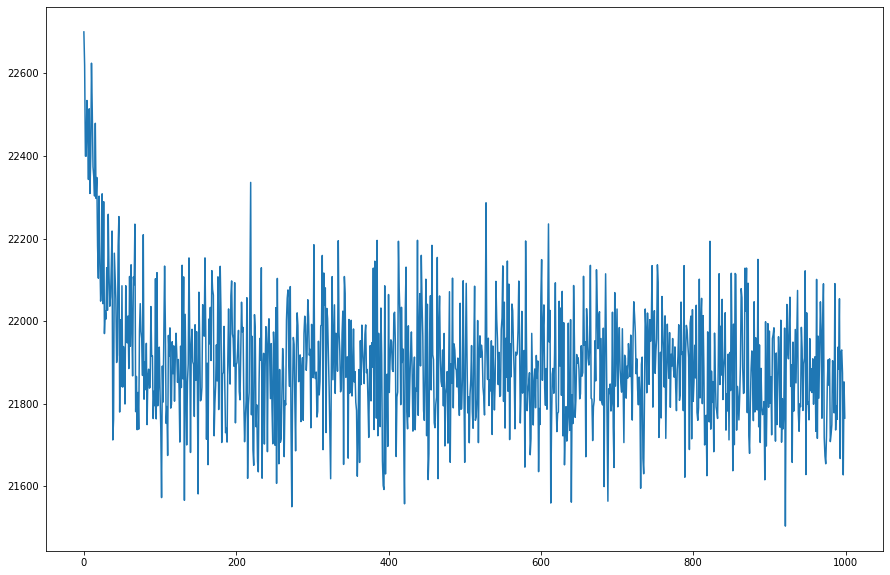

{'AutoNormal.locs.lambda1': array(-0.02682315, dtype=float32),
 'AutoNormal.scales.lambda1': array(0.97079897, dtype=float32),
 'AutoNormal.locs.lambda2': array(-0.08051787, dtype=float32),
 'AutoNormal.scales.lambda2': array(0.03451372, dtype=float32),
 'AutoNormal.locs.lambda3': array(-0.7443058, dtype=float32),
 'AutoNormal.scales.lambda3': array(0.07290062, dtype=float32),
 'AutoNormal.locs.lambda4': array(0.7942055, dtype=float32),
 'AutoNormal.scales.lambda4': array(0.04933999, dtype=float32),
 'AutoNormal.locs.lambda5': array(0.72278017, dtype=float32),
 'AutoNormal.scales.lambda5': array(0.0334681, dtype=float32),
 'AutoNormal.locs.lambda6': array(0.12767197, dtype=float32),
 'AutoNormal.scales.lambda6': array(0.01929843, dtype=float32),
 'AutoNormal.locs.lambda7': array(-0.7835577, dtype=float32),
 'AutoNormal.scales.lambda7': array(0.03560446, dtype=float32),
 'AutoNormal.locs.lambda8': array(0.16854411, dtype=float32),
 'AutoNormal.scales.lambda8': array(0.8299522, dtype=flo

In [167]:
train(samples, num_steps=1000, num_obs=2000, model=ProposedModel, guide=autonormal)

# Twin-World Counterfactuals 

1. Abduction: Predict the ‘state of the world’ (the exogenous noise, ✏) that is compatible with
the observations, x, i.e. infer PG(✏|x).

2. Action: Perform an intervention (e.g. do(xk := xek)) corresponding to the desired manipulation, resulting in a modified SCM Ge = Gx;do(xek) = (Se, PG(✏|x)).
    
3. Prediction: Compute the quantity of interest based on the distribution entailed by the counterfactual SCM, PG(x).

In [ ]:
# Infer exogenous noise
cond_sample = pyro.condition(ProposedModel, data=samples)
cond_trace = poutine.trace(cond_sample).get_trace()

output = {}
for name, node in cond_trace.nodes.items():
    if 'fn' not in node.keys():
        continue

    fn = node['fn']
    if isinstance(fn, Independent):
        fn = fn.base_dist
    if isinstance(fn, TransformedDistribution):
        output[name + '_base'] = ComposeTransform(fn.transforms).inv(node['value'])